# Esercitazione 5
### Laboratorio di Simulazione Numerica

Il materiale relativo all'esercitazione cinque è suddiviso come segue nella cartella `Lab_05`: i codici sono raccolti nella cartella `Code/5.1` corrispondente alla consegna dell'esercitazione; i risultati relativi agli esercizi svolti sono raccolti nella cartella `Results`;

---

Il Jupyter Notebook è organizzato come segue:
- 5.0 caricamento dei pacchetti e introduzione;
- 5.1 stima di $\langle r \rangle_{\Psi_{100}}$ e $\langle r \rangle_{\Psi_{210}}$ e delle relative incertezze utilizzando simulazioni basate sull'algoritmo di Metropolis _aka_ $M(RT)^2$. 

## 5.0 - caricamento dei pacchetti e introduzione

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import tqdm as tqdm

sns.set_theme(font_scale=1.7, style='whitegrid') 

In [42]:
noequi = np.loadtxt("Results/noequi.dat")          # 10'000 passi senza equilibrare
equi = np.loadtxt("Results/equi.dat")              # 10'000 passi + 1'000 di equilibrazione 

In [87]:
H100 = np.loadtxt("Results/H100.dat")
H210 = np.loadtxt("Results/H210.dat")

###  L'algoritmo $M(RT)^2$ 

L'algoritmo di Metropolis permette di effettuare il campionamento statistico di una distribuzione di probabilità $P_{eq}$ di qualsiasi dimensione e indipendentemente dalla sua complessità analitica. Questo enorme vantaggio è dovuto all'idea di produrre un processo di Markov all'interno dello spazio campione, durante il quale ogni passo $x\to x'$ della catena viene  eseguito in accordo con la matrice $K(x'|x)$, che è anche detta _matrice di trasferimento stocastico_. 

Abbiamo visto a lezione che una $K$ strettamente positiva e regolare ci garantisce l'esistenza di una distribuzione di probabilità $p(x)>0$ che è invariante sotto l'azione del nucleo $K$. Applicando il Metropolis ciò che facciamo è esattamente l'opposto: cerchiamo un nucleo stocastico da associare ad una distribuzione nota ($P_{eq}$ appunto) e per la quale essa sia invariante. In questo modo, avremo uno strumento che è in grado di fornirci un campionamento capace, al tendere del numero di realizzazioni all'infinito, di approssimare la $P_{eq}$.

Ai fini dell'implementazione di $M(RT)^2$ è utile scomporre il nucleo stocastico in due contributi fattorizzati: 

$$ K (x'|x) = T(x'|x)\cdot A(x'|x),$$ 

in cui $T$ e $A$ sono dette rispettivamente matrice di trasferimento e matrice di accettazione. Le scelte che si possono fare nel definire le matrici coinvolte nel Metropolis possono essere molteplici; la più nota (che è anche quella implementata in questo esercizio) è la seguente: 

$$ A(x'|x)=\min (1, q(x'|x)), \qquad \texttt{con} \qquad q(x'|x)=\frac{T(x'|x)P_{eq}(x')}{T(x|x')P_{eq}(x)}\geq 0. $$

In sostanza, $T$ serve per generare il nuovo punto $x'$ nello spazio campione. A questo punto si valuta la probabilità $\alpha$ di accettazione del punto tramite $A(x'|x)$. Infine, si accetta $x'$ con probabilità $\alpha$. 

---

### $P_{eq}$ sul quale lo applichiamo

La consegna di questo esercizio ci richiede di effettuare il campionamento delle distribuzioni di probabilità della posizione dell'elettrone attorno al nucleo dell'atomo di idrogeno nel caso in cui le funzioni d'onda corrispondano agli autostati di _ground state_ e primo stato eccitato, rispettivamente $\Psi_{100}, \Psi_{210}$:

$$
\Psi_{1,0,0}(r,\theta,\phi)=
\frac{a_0^{-3/2}}{\sqrt{\pi}} e^{-r/a_0} 
\qquad \texttt{e} \qquad 
\Psi_{2,1,0}(r,\theta,\phi)=
\frac{a_0^{-5/2}}{8}\sqrt{\frac{2}{\pi}} r e^{-r/2a_0} \cos(\theta),
$$

da cui le probabilità (che esprimo in questo caso in coordinate cartesiane): $|\Psi_{100}(x,y,z)|^2$ e $|\Psi_{210}(x,y,z)|^2$. Tramite l'algoritmo di Metropolis otteniamo un campione di punti corrispondenti alle posizioni assunte da un _walker_ nel corso del suo cammino stocastico; al crescere del numero di punti il campione approssima asintoticamente la distribuzione di probabilità. Utilizzando questo stesso campione siamo dunque in grado di calcolare (utilizzando il metodo delle medie a blocchi) il valore di $\langle r \rangle_{\Psi_{100}}$ e $\langle r \rangle_{\Psi_{210}}$ richiesto dalla consegna.

---

## 5.1 - utilizzare $M(RT)^2$ per stimare $\langle r \rangle_{\Psi_{100}}$ e $\langle r \rangle_{\Psi_{210}}$

### Aspetti generali del mio codice

L'algoritmo $M(RT)^2$ è implementato nella classe `metropolis.cpp/h`, al cui interno ho definito i metodi necessari per concretizzare la classe `Measure` che viene richiamata nel del metodo `blocking`, come già spiegato in precedenza. I punti nello spazio campione sono interpretati per mezzo della classe `Position`, i cui data membri sono le coordinate cartesiane di un punto nello spazio tridimensionale e tramite la quale è possibile accedere e modificare le coordinate, trasformarle in coordinate sferiche e svolgere dei passi casuali (uniformi o gaussiani) di lunghezza `stepsize` nello spazio 3D. 

Il cuore dell'algoritmo di Metropolis è descritto nel metodo `try_step()`, all'interno del quale:
1. il mio walker (interpretato da `Position _x`) viene sottoposto ad un passo (ad esempio `_x -> gaussian_step(stepsize)`);
2. la vecchia e la nuova posizione di `_x` vengono utilizzate per calcolare il valore della p.d.f. (che è $P_{eq}$) in quei punti: ad esempio `pdf -> eval(_x)`;
3. in modo analogo a quello esposto nei paragrafi precedenti, la nuova posizione viene accettata o rigettata.

Nello svolgimento dell'esercizio ho eseguito in ogni run $M=10^6$ volte il metodo `try_step()` e calcolato il tasso di accettazione complessivo durante l'esecuzione. Nell'algoritmo di Metropolis è infatti importante impostare i parametri del processo stocastico in modo che il tasso di accettazione medio sia il più vicino possibile al 50%. Questa, che è una regola empirica, ci permette di evitare che l'algoritmo sia soggetto ad alta correlazione (acc. $\to1$) o bassa efficienza (acc. $\to 0$).

### Equilibrare il processo

Uno dei problemi dell'algoritmo di $M(RT)^2$ riguarda il caso in cui l'_walker_ venga inizializzato in una posizione "scomoda" (troppo lontano dalla regione di massima densità della distribuzione che vogliamo campionare). Per visualizzare questa necessità ho provato ad eseguire la simulazione del _ground state_ dell'atomo di idrogeno inizializzando l'_walker_ nel punto di coordinate $x_0=(50,50,50)$ ed eseguendo $M=10^4$ passi estratti da una $T$ uniforme. Ho lasciato evolvere con e senza l'aggiunta di $N_{equi}=10^3$ passi di equilibrazione. Riporto il risultato nel grafico seguente.

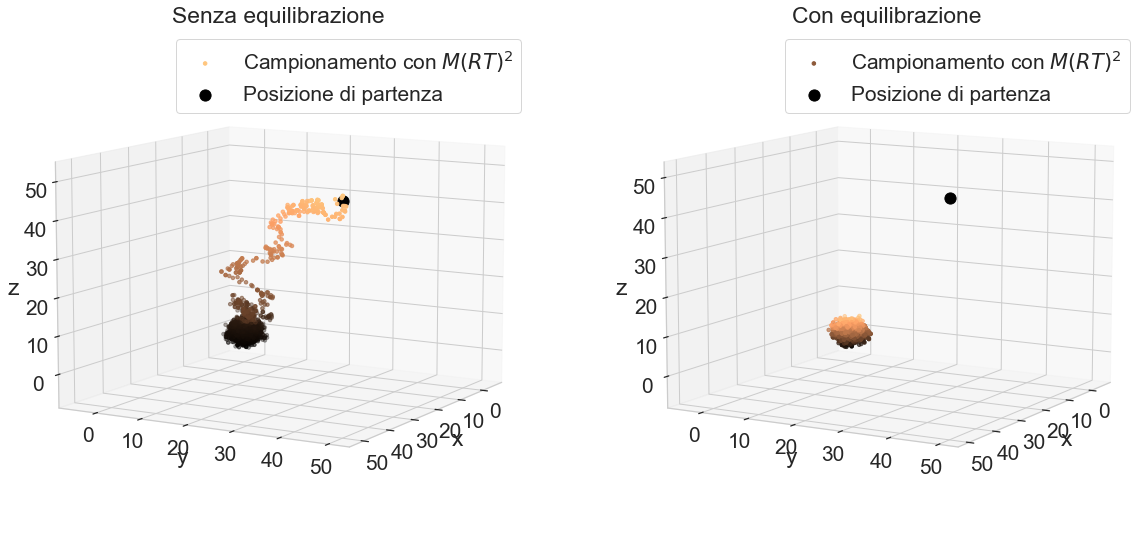

In [40]:
sns.set_theme(font_scale=1.9, style='whitegrid') 

X = noequi.T[0]
Y = noequi.T[1]
Z = noequi.T[2]

fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(1,2,1, projection='3d')
plt.title('Senza equilibrazione')
ax.scatter(X, Y, Z, c=Z, marker='.', s=50, label='Campionamento con $M(RT)^2$', cmap='copper')
ax.scatter(50,50,50, color='black', marker='.', s=500, label='Posizione di partenza')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 30)
plt.legend()

X = equi.T[0]
Y = equi.T[1]
Z = equi.T[2]

ax1 = fig.add_subplot(1,2,2, projection='3d')
plt.title('Con equilibrazione')
ax1.scatter(X, Y, Z, c=Z, marker='.', s=50, label='Campionamento con $M(RT)^2$', cmap='copper')
ax1.scatter(50,50,50, color='black', marker='.', s=500, label='Posizione di partenza')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.view_init(10, 30)
plt.legend()
plt.show()

__Figura 1:__ a sinistra, $M=10^4$ passi di Metropolis partendo da $x_0=(50,50,50)$ senza equilibrare il sistema. A destra una simulazione identica a cui ho aggiunto $N_{equi}=10^3$ passi di equilibrazione.

### Affrontare la correlazione tra i dati generati

Uno dei più grossi problemi dell'algoritmo di Metropolis è che si basa sulla generazione di una sequenza di passi che, intrinsecamente, contengono dunque un certo grado di correlazione. Proprio per evitare di effettuare delle misure che siano tra loro correlate, utilizziamo anche in questa sede il metodo delle medie a blocchi. Andando ad effettuare una misura su ogni blocco di realizzazioni di un certo fenomeno, se scegliamo una taglia opportunamente grande per i blocchi, siamo in grado di confinare ai bordi delle sequenze di dati che contribuiscono ad una singola misura l'autocorrelazione; in questo modo potremo affermare con maggior sicurezza di aver effettuato delle misure scorrelate. Per valutare con coscienza la taglia dei blocchi su cui effettuare le misure eseguo il calcolo della funzione di autocorrelazione tra le realizzazioni al crescere della loro distanza $\tau$ (espressa in termini di passi di Metropolis) per $\tau\in[0,200]$.

Ho svolto tale procedimento utilizzando una sequenza di $M=10^6$ realizzazioni.

Sconsiglio di eseguire la cella seguente, richiede un tempo $t\sim 9$ min.

In [52]:
AC = []
npoints = 200
Nstep = 1000000

print('Calcolo il valore della funzione di autocorrelazione')
for tau in tqdm.tqdm(range(npoints)):
    x_min_tau = H100[:Nstep - tau]
    x_plu_tau = H100[tau:]
    n = len(x_min_tau)
    AC.append((sum(x_min_tau * x_plu_tau)/n - sum(x_min_tau) / 
            n * sum(x_plu_tau) / n)/np.std(H100)**2)

  0%|          | 0/200 [00:00<?, ?it/s]

Calcolo il valore della funzione di autocorrelazione


100%|██████████| 200/200 [09:00<00:00,  2.70s/it]


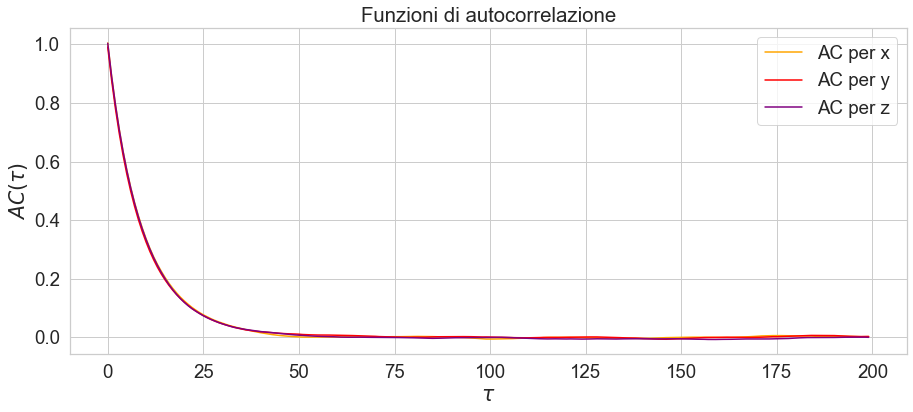

In [76]:
AC = np.asarray(AC)

plt.figure(figsize=(15,6))
plt.title('Funzioni di autocorrelazione')
plt.plot(AC.T[0], label='AC per x', color='orange')
plt.plot(AC.T[1], label='AC per y', color='red')
plt.plot(AC.T[2], label='AC per z', color='purple')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$AC(\tau)$')
plt.show()


__Figura 2:__ rispettivamente in arancione, rosso e viola sono rappresentati i valori dell'autocorrelazione calcolata utilizzando dati distanti $\tau$ nelle sequenze di valori ottenuti per $x,y,z$ in funzione di $\tau$. L'andamento della curva indica la necessità di prendere in considerazione blocchi di taglia non inferiore a $L=100$.

### Eseguire i campionamenti utilizzando due diversi $T$

Adottate tutte queste precauzioni, siamo pronti infine per effettuare le stime richieste dalla consegna. Per farlo, eseguo due volte il codice, cambiando il tipo di passo che viene proposto in `try_step`, impostando una volta `method = "uniform"` e un'altra `method = "gaussian"`:
- __passo uniforme__, riporto solo la coordinata x a titolo d'esempio: `_x += Random -> Rannyu(-stepsize,stepsize)`.
- __passo gaussiano__, ancora una volta riporto x: `_x += Random -> Gauss(0, stepsize)`.

Per effettuare la stima dei valori di $\langle r \rangle_{\Psi_{100}}$ e $\langle r \rangle_{\Psi_{210}}$ ho utilizzato entrambi i metodi; Ho stabilito di utilizzare $M=5\cdot 10^6$ realizzazioni e $N=150$ blocchi per i motivi espressi in precedenza. La singola realizzazione all'interno del metodo `blocking` è implementata eseguendo un passo del Metropolis e calcolando la distanza dall'origine tramite il metodo `get_radius()` implementato nella classe `Position`.

---

Ho dovuto eseguire una serie di tentativi prima di selezionare un valore di `stepsize` che mi garantisse il rispetto della regola empirica sul tasso di accettazione (circa 50%).
- Per il ground state ho utilizzato i nuclei: $\,\mathcal{U}(0,1.235)$ e $\mathcal{N}(0,0.75)$;
- per il primo stato eccitato invece i nuclei: $\,\mathcal{U}(0,2.955)$ e $\mathcal{N}(0,1.85)$;


---

Nei seguenti campionamenti l'_walker_ parte dall'origine: $\vec{x}_0=(0,0,0)$.

In [37]:
uni_block_100 = np.loadtxt("Results/uniform_blockin_on_100.dat")
uni_block_210 = np.loadtxt("Results/uniform_blockin_on_210.dat")

In [38]:
gau_block_100 = np.loadtxt("Results/gaussian_blockin_on_100.dat")
gau_block_210 = np.loadtxt("Results/gaussian_blockin_on_210.dat")

### Stime con blocking e passo uniforme

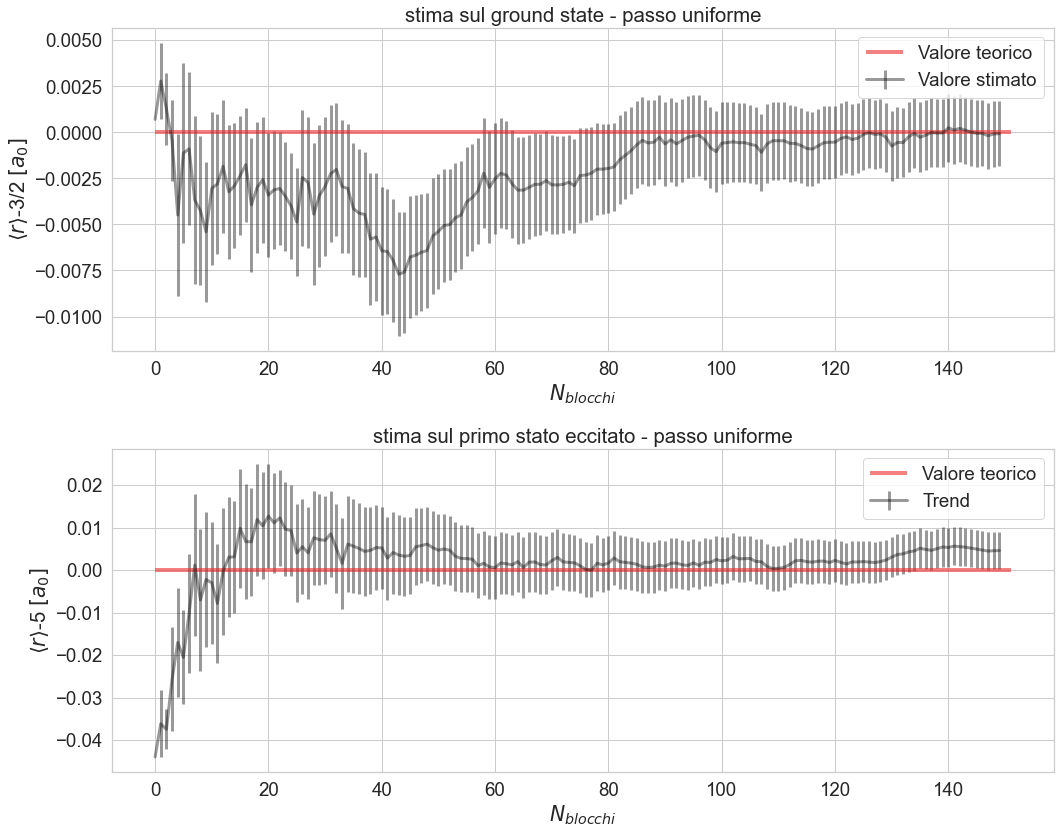

In [48]:
x = np.arange(150)

plt.figure(figsize=(15,12))

plt.subplot(2,1,1)
plt.title("stima sul ground state - passo uniforme")
plt.errorbar(x, uni_block_100.T[0]-1.5, yerr=uni_block_100.T[1], color='black', alpha=0.4, label='Valore stimato', linewidth=3)
plt.hlines(0,0,151, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel(r'$\langle r \rangle$-3/2 $[a_0]$')
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.subplot(2,1,2)
plt.title("stima sul primo stato eccitato - passo uniforme")
plt.errorbar(x, uni_block_210.T[0]-5, yerr=uni_block_210.T[1], color='black', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(0,0,151, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel(r'$\langle r \rangle$-5 $[a_0]$')
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.tight_layout()
plt.savefig("block_on_hydro.png")
plt.show()

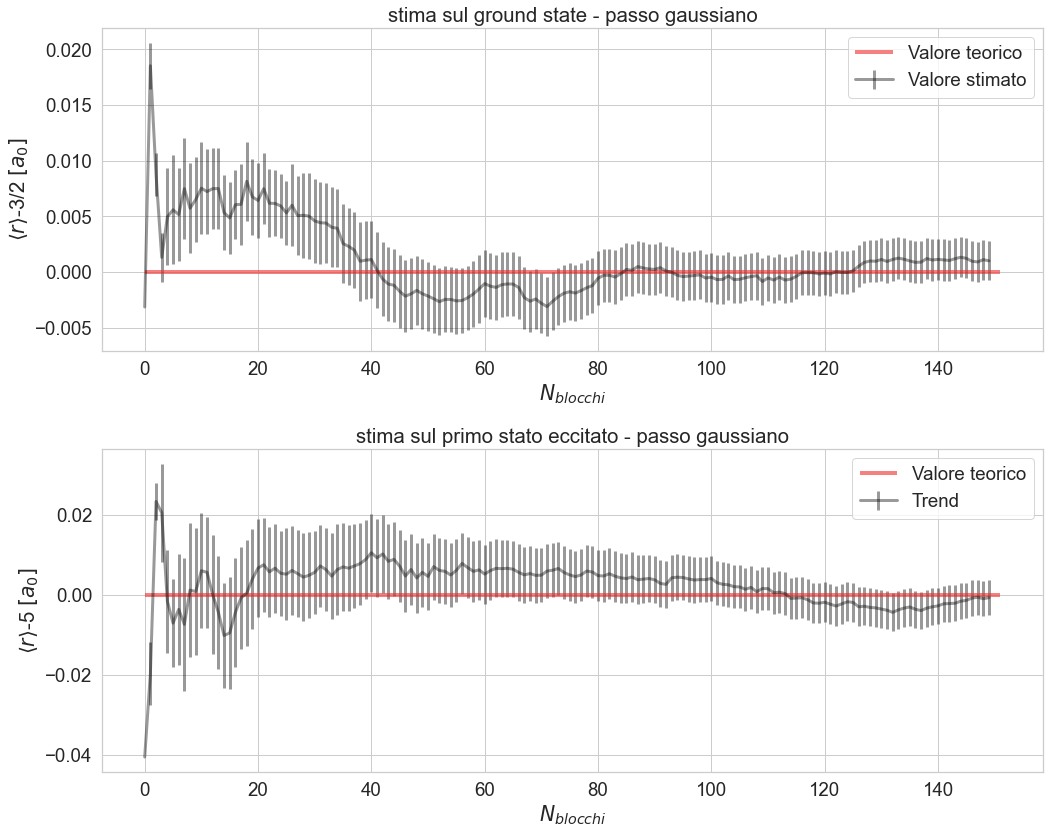

In [49]:
x = np.arange(150)

plt.figure(figsize=(15,12))

plt.subplot(2,1,1)
plt.title("stima sul ground state - passo gaussiano")
plt.errorbar(x, gau_block_100.T[0]-1.5, yerr=uni_block_100.T[1], color='black', alpha=0.4, label='Valore stimato', linewidth=3)
plt.hlines(0,0,151, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel(r'$\langle r \rangle$-3/2 $[a_0]$')
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.subplot(2,1,2)
plt.title("stima sul primo stato eccitato - passo gaussiano")
plt.errorbar(x, gau_block_210.T[0]-5, yerr=uni_block_210.T[1], color='black', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(0,0,151, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel(r'$\langle r \rangle$-5 $[a_0]$')
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.tight_layout()
plt.savefig("block_on_hydro.png")
plt.show()

In [46]:
print('MISURE EFFETTUATE PER IL GROUND STATE')
print("Misura finale GS, nucleo uniforme : ", uni_block_100.T[0][149],
      " avente incertezza: ", uni_block_100.T[1][149])
print("Misura finale GS, nucleo gaussiano: ", gau_block_100.T[0][149],
      " avente incertezza: ", gau_block_100.T[1][149])
print("------------------------------------------------------------")
print('MISURE EFFETTUATE PER IL PRIMO STATO ECCITATO')
print("Misura finale 2p, nucleo uniforme : ", uni_block_210.T[0][149],
      " avente incertezza: ", uni_block_210.T[1][149])
print("Misura finale 2p, nucleo gaussiano: ", gau_block_210.T[0][149],
      " avente incertezza: ", gau_block_210.T[1][149])

MISURE EFFETTUATE PER IL GROUND STATE
Misura finale GS, nucleo uniforme :  1.49992  avente incertezza:  0.00176797
Misura finale GS, nucleo gaussiano:  1.50101  avente incertezza:  0.00174955
------------------------------------------------------------
MISURE EFFETTUATE PER IL PRIMO STATO ECCITATO
Misura finale 2p, nucleo uniforme :  5.0046  avente incertezza:  0.00433877
Misura finale 2p, nucleo gaussiano:  4.99935  avente incertezza:  0.00455964


__Figura 3:__ nelle figure precedenti ho rappresentato le misure iterative e le rispettive incertezze ottenute tramite media a blocchi nei vari casi analizzati. Possiamo notare che i due metodi ci forniscono risultati statisticamente equivalenti. Interessante dunque sottolineare che tramite due nuclei stocastici diversi tra loro, tramite $M(RT)^2$, abbiamo ricavato dei risultati davvero simili. Le prestazioni del Metropolis non dipendono dunque dal tipo di nucleo che si sceglie, purché esso soddisfi (come in questo caso) le ipotesi di ergodicità e regolarità richieste dal teorema di Markov.

### Visualizziamo i campionamenti (step uniforme)

A titolo d'esempio, mostro le realizzazioni ottenute tramite un campionamento $M(RT)^2$ eseguito con nucleo stocastico uniforme.

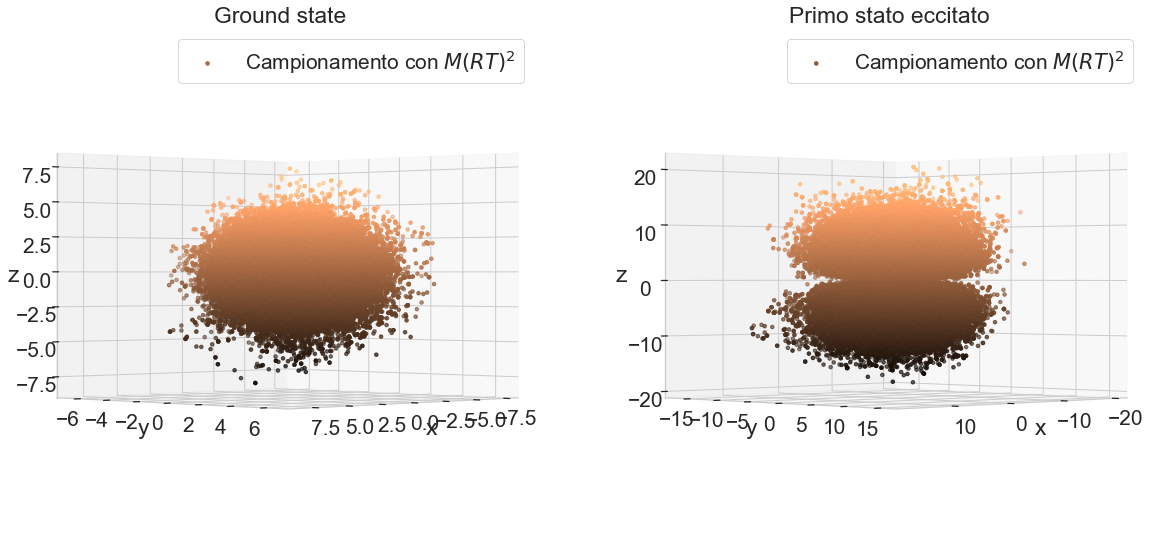

In [93]:
sns.set_theme(font_scale=1.9, style='whitegrid') 

X = H100.T[0]
Y = H100.T[1]
Z = H100.T[2]

fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(1,2,1, projection='3d')
plt.title('Ground state')
ax.scatter(X, Y, Z, c=Z, marker='.', s=50, label='Campionamento con $M(RT)^2$', cmap='copper')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(0, 45)
plt.legend()

X = H210.T[0]
Y = H210.T[1]
Z = H210.T[2]

ax1 = fig.add_subplot(1,2,2, projection='3d')
plt.title('Primo stato eccitato')
ax1.scatter(X, Y, Z, c=Z, marker='.', s=50, label='Campionamento con $M(RT)^2$', cmap='copper')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.view_init(0, 45)
plt.legend()
plt.show()

__Figura 5:__ $M=10^6$ campionamenti eseguiti successivamente ad un'equilibrazione tramite $M(RT)^2$ in cui i passi vengono proposti secondo un nucleo stocastico uniforme. Notiamo che le configurazioni corrispondono a quelle attese dalla teoria. 